# 02 · Bike Infrastructure Analysis

## Objective
The objective of this notebook is to analyze the spatial distribution and characteristics of the cycling infrastructure in New York City to:
- Visualize the layout of bike routes across the city.
- Compare the prevalence of different types of lanes (e.g., one-way vs. two-way).
- Understand how urban density impacts infrastructure design choices.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Data Loading

The NYC bike infrastructure dataset, along with neighborhood boundaries and street maps, are loaded below to establish the spatial context for the analysis.

In [2]:
bike_infra = gpd.read_file("../data/raw/infraestructure/New_York_City_Bike_Routes_20260123.geojson")
nyc_map = gpd.read_file("../data/raw/city/Borough_Boundaries_20260126.geojson")
nyc_streets = gpd.read_file("../data/raw/city/Centerline_20260126.geojson")

bike_infra.head()

segmentid  bikeid prevbikeid   status boro         street        fromstreet  \
0    2579.0  6562.0         NA  Current    5     HYLAN BLVD         HOLTEN AV   
1    5033.0  4272.0       None  Current    5  MERRYMOUNT ST  RICHMOND HILL RD   
2   10186.0  2107.0         NA  Current    5     CLOVE ROAD     RICHMOND TERR   
3   20716.0   942.0         NA  Current    3           5 AV             23 ST   
4  126857.0   951.0         NA  Current    3       6 AVENUE             67 ST   

           tostreet onoffst facilitycl  ...     grnwy  \
0          LUTEN AV      ON         II  ...  Greenway   
1       ROCKLAND AV      ON         II  ...      None   
2        FOREST AVE      ON        III  ...      None   
3             50 ST      ON        III  ...      None   
4  FT HAMILTON PKWY      ON        III  ...      None   

                   gwsystem gwsys2            spur gwyjuris  \
0  Staten Island Waterfront   None  Main Alignment   NYCDOT   
1                      None   None            None     None   
2                      None   None            None     None   
3                      None   None            None     None   
4                      None   None            None     None   

                  :id           :version                      :created_at  \
0  row-nqkr-s8ka-q5qw  rv-rm8p_vv4q_9s7u 2025-08-18 15:45:55.457000+00:00   
1  row-ycpz_zq5h~zpkj  rv-znn4.hsfx.mygh 2025-08-18 15:45:55.457000+00:00   
2  row-hq66_65rx~9g3a  rv-kp25_chfv.9jea 2025-08-18 15:45:55.457000+00:00   
3  row-ki24-r6ta_3wq4  rv-b5cc-tq9i.mgrt 2025-08-18 15:45:55.457000+00:00   
4  row-db9g-uzzj~8rb9  rv-6c9r_urm2_yat4 2025-08-18 15:45:55.457000+00:00   

                       :updated_at  \
0 2025-08-18 15:45:55.457000+00:00   
1 2025-08-18 15:45:55.457000+00:00   
2 2025-08-18 15:45:55.457000+00:00   
3 2025-08-18 15:45:55.457000+00:00   
4 2025-08-18 15:45:55.457000+00:00   

                                            geometry  
0  MULTILINESTRING ((-74.19243 40.52174, -74.1951...  
1  MULTILINESTRING ((-74.16031 40.58903, -74.1612...  
2  MULTILINESTRING ((-74.12632 40.63525, -74.1259...  
3  MULTILINESTRING ((-74.00974 40.64567, -74.0103...  
4  MULTILINESTRING ((-74.02089 40.62654, -74.0209...  

[5 rows x 29 columns]

## Spatial Configuration of the Network

The geographical distribution of the cycling infrastructure is visualized below. The network is overlaid on the city's administrative boundaries to provide a comprehensive view of the coverage across different boroughs.

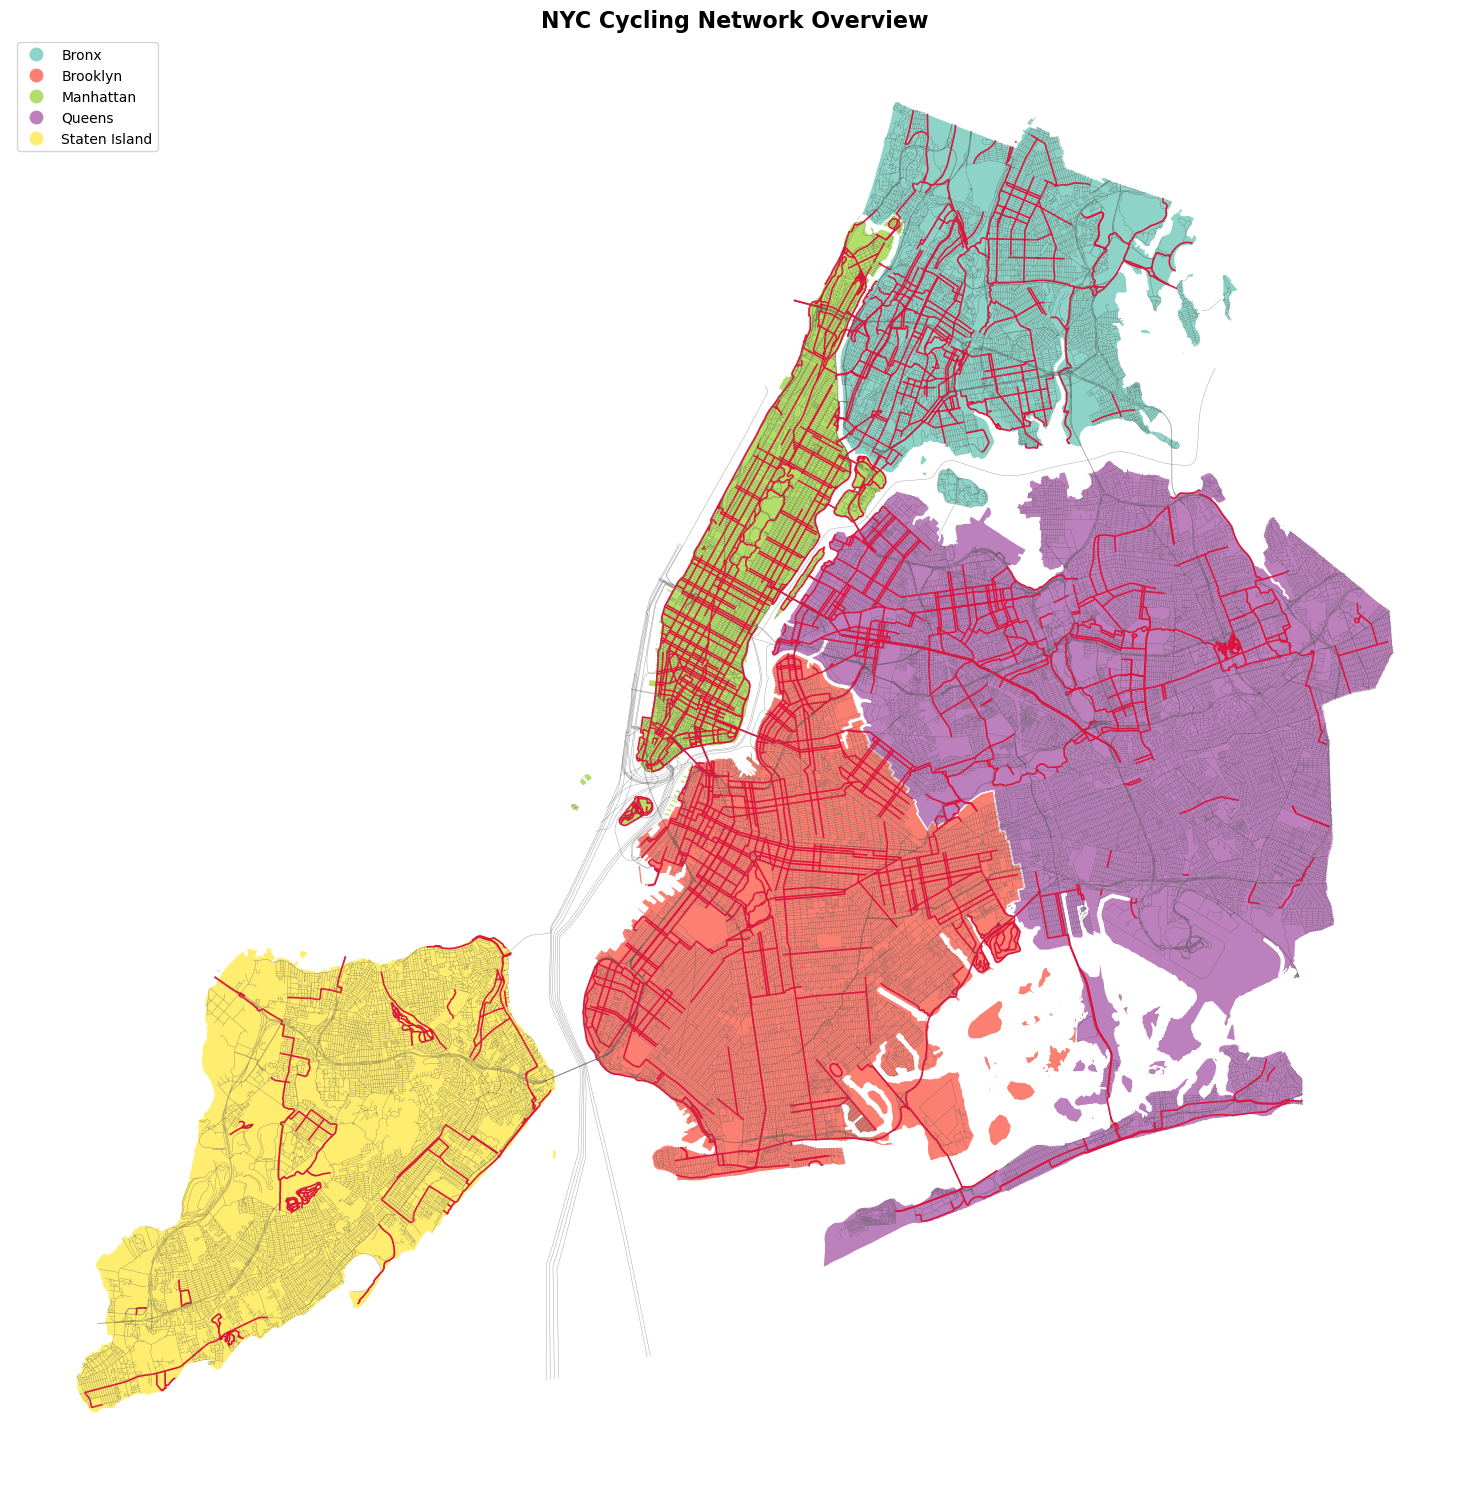

In [3]:
fig, ax = plt.subplots(figsize=(15, 15))

nyc_map.plot(ax= ax, 
             cmap= 'Set3',
             column= 'boroname',
             edgecolor= 'white',
             zorder= 0,
             legend= True,
             legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0, 1)})

nyc_streets.plot(ax= ax, 
                 color= '#555555', 
                 linewidth= 0.3,
                 alpha= 0.6,
                 zorder= 1)

bike_infra.plot(ax= ax, 
                color= 'crimson', 
                linewidth= 1.2, 
                zorder= 2)

ax.set_title("NYC Cycling Network Overview", fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

A distinct core-periphery pattern is observed regarding the density of the cycling network:

1.  **Manhattan as the Hub:** This borough exhibits the highest concentration and connectivity of bike lanes, serving as the central node of the system.
2.  **Spillover Effect:** The boroughs of The Bronx, Queens, and Brooklyn show significant infrastructure density in areas adjacent to Manhattan. However, a clear gradient is visible as the distance from the city center increases, the network becomes fragmented and sparse.
3.  **Staten Island Isolation:** Being geographically detached, Staten Island features the lowest infrastructure density. Cycling paths here are almost exclusively limited to recreational green spaces and select major avenues, lacking a cohesive commuting network.

## Infrastructure Classification

The dataset provides detailed metadata for each street segment, specifying the facility type for both "to" and "from" directions. To improve visualization clarity, the diverse infrastructure codes have been aggregated into three primary categories based on safety levels:

* **Protected:** Dedicated cycling paths physically separated from vehicular traffic (e.g., by bollards, parked cars, or curbs), offering the highest safety standard.
* **Lane:** Standard designated lanes separated only by pavement markings (paint), without physical barriers.
* **Shared:** Routes where cyclists share the roadway with motor vehicles (e.g., sharrows), representing the lowest level of segregation.

A specific logic was implemented to visualize segments where the infrastructure type differs by direction (e.g., a protected path on one side and a shared lane on the other). The processing rules are as follows:

1.  **Unidirectional / Symmetric Bidirectional:** If the street has a bike lane in only one direction, or identical facility types in both directions, the segment is assigned directly to the corresponding category.
2.  **Asymmetric Bidirectional (Split & Offset):** In cases where a single street segment contains different facility types for each direction, the geometry is duplicated and split. A lateral spatial offset of 10 feet is applied to each linestring (left and right relative to the digitization direction). This technique prevents visual overlap and allows for the simultaneous distinct visualization of both infrastructure types on the map.

In [5]:
# Convert to feet for accurate offsetting
bike_proj = bike_infra.to_crs(epsg=2263)

bike_proj['ft'] = bike_proj['ft_facilit'].fillna('None')
bike_proj['tf'] = bike_proj['tf_facilit'].fillna('None')

dfs_list = []

# CASE A: Exists in both directions and are the same
# Logic: ft == tf and not 'None'
mask_equal = (bike_proj['ft'] == bike_proj['tf']) & (bike_proj['ft'] != 'None')
df_equal = bike_proj[mask_equal].copy()
df_equal['type'] = df_equal['ft']
dfs_list.append(df_equal[['geometry', 'type']])

# CASE B: Only exists in one direction
# LLogic: They are different and one of them is 'None'
mask_oneway = (bike_proj['ft'] != bike_proj['tf']) & ((bike_proj['ft'] == 'None') | (bike_proj['tf'] == 'None'))
df_oneway = bike_proj[mask_oneway].copy()
df_oneway['type'] = np.where(df_oneway['ft'] != 'None', df_oneway['ft'], df_oneway['tf'])
dfs_list.append(df_oneway[['geometry', 'type']])

# --- CASE C: Exists in both directions and are different
# LLogic: None is 'None' AND they are different from each other
mask_diff = (bike_proj['ft'] != 'None') & (bike_proj['tf'] != 'None') & (bike_proj['ft'] != bike_proj['tf'])
df_diff = bike_proj[mask_diff].copy()

if not df_diff.empty:
    df_diff_exploded = df_diff.explode(index_parts=False)

    # Sub-case C1: Direction FT (From-To) -> Right Side
    df_c1 = df_diff_exploded.copy()
    df_c1['geometry'] = df_c1.geometry.apply(
        lambda x: x.parallel_offset(10, 'right', join_style=3) if x.geom_type == 'LineString' else x
    )
    df_c1['type'] = df_c1['ft']
    
    # Sub-case C2: Direction TF (To-From) -> Left Side
    df_c2 = df_diff_exploded.copy()
    df_c2['geometry'] = df_c2.geometry.apply(
        lambda x: x.parallel_offset(10, 'left', join_style=3) if x.geom_type == 'LineString' else x
    )
    df_c2['type'] = df_c2['tf']
    
    dfs_list.extend([df_c1[['geometry', 'type']], df_c2[['geometry', 'type']]])

clean_bike_df = pd.concat(dfs_list, ignore_index=True)

color_map = {
    'Protected': '#2ca02c',
    'Boardwalk': '#2ca02c',
    'Curbside': '#2ca02c',
    'Curbside Buffered': '#2ca02c',
    'Conventional': '#1f77b4',
    'Conventional Buffered': '#1f77b4',
    'Wide Parking Lane': '#1f77b4',
    'Ped Plaza': '#1f77b4',
    'Shared': '#ff7f0e',
    'Signed Route': '#ff7f0e',
    'Sidewalk': '#ff7f0e',
    'Link': '#ff7f0e',
}
clean_bike_df['color'] = clean_bike_df['type'].map(color_map).fillna('grey')

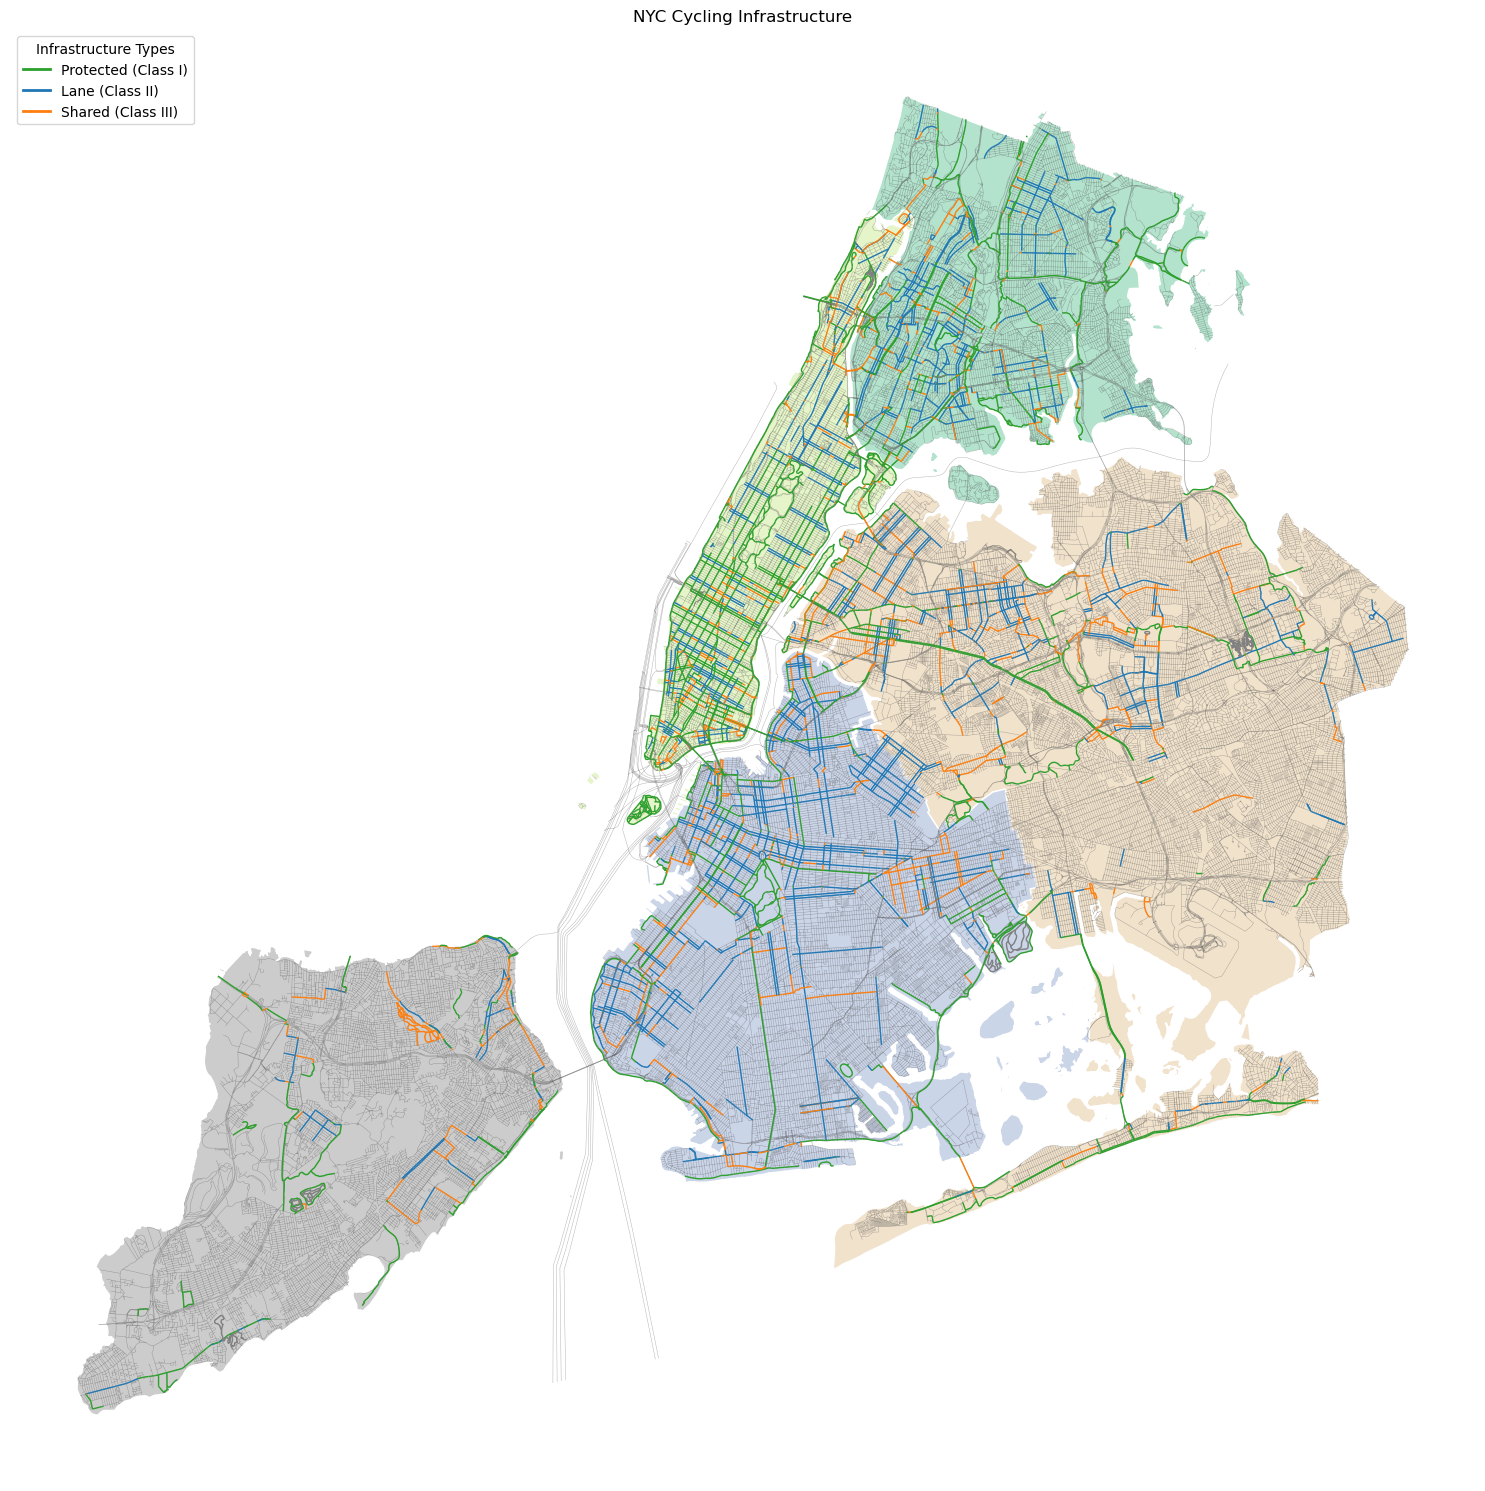

In [6]:
fig, ax = plt.subplots(figsize=(15, 15))

nyc_map.to_crs(epsg=2263).plot(ax=ax, 
                               column='boroname', 
                               cmap='Pastel2', 
                               edgecolor='white', 
                               zorder=0)
nyc_streets.to_crs(epsg=2263).plot(ax=ax, 
                                   color='#555555', 
                                   linewidth=0.3, 
                                   alpha=0.5, 
                                   zorder=1)

clean_bike_df.plot(ax=ax, 
                   color=clean_bike_df['color'], 
                   linewidth=1, 
                   zorder=2)

ax.plot([], [], color='#2ca02c', linewidth=2, label='Protected (Class I)')
ax.plot([], [], color='#1f77b4', linewidth=2, label='Lane (Class II)')
ax.plot([], [], color='#ff7f0e', linewidth=2, label='Shared (Class III)')

ax.legend(loc='upper left', title="Infrastructure Types")

ax.set_axis_off()
ax.set_title("NYC Cycling Infrastructure")
plt.tight_layout()
plt.show()

A preliminary visual inspection reveals a significant prevalence of Protected Bicycle Lanes, indicating a structural commitment to cyclist safety. Furthermore, a high density of Standard Bike Lanes (Class II) is observed along major avenues and primary thoroughfares, serving as the connective tissue of the network between protected segments.

## Analysis of Lane Directionality: One-way vs. Two-way

As previously explained, the cycling network comprises both unidirectional and bidirectional segments. To better understand potential cyclist flow and route connectivity within the urban grid, the infrastructure is analyzed based on permitted travel directions.

The categorization is derived from the `ft_clean` (From-To) and `tf_clean` (To-From) attributes:
* **Two-way:** Assigned when both columns contain valid infrastructure data, indicating flow is permitted in both directions.
* **One-way:** Assigned when only one of the two columns contains data (indicating the other direction is null or not applicable).

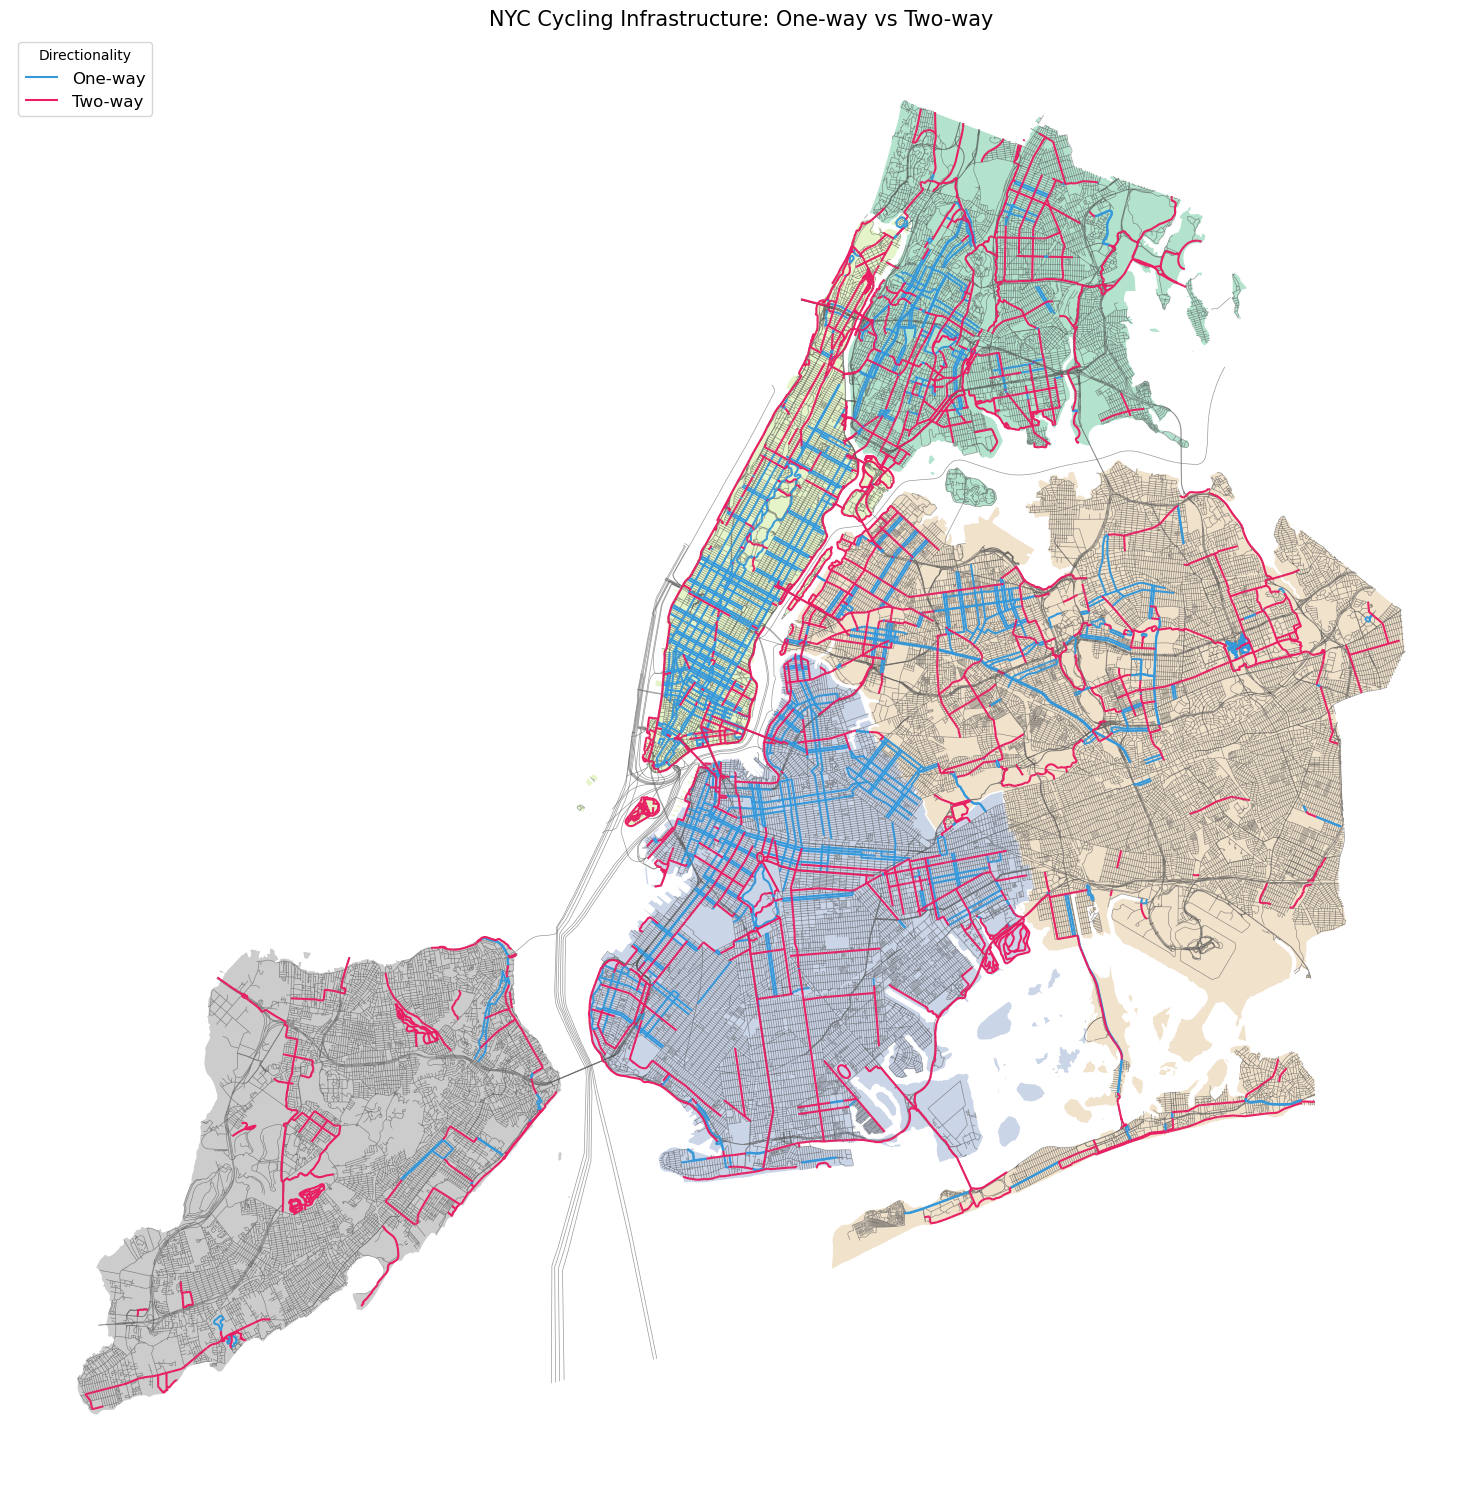

In [7]:
bike_data = bike_infra.to_crs(epsg=2263).copy()

bike_data['ft_clean'] = bike_data['ft_facilit'].replace('', np.nan)
bike_data['tf_clean'] = bike_data['tf_facilit'].replace('', np.nan)

#  Condition 1: Two-way (Both columns have data)
mask_two_way = (bike_data['ft_clean'].notna()) & (bike_data['tf_clean'].notna())

# Condition 2: One-way (Some have data, but NOT both at the same time)
mask_has_any = (bike_data['ft_clean'].notna()) | (bike_data['tf_clean'].notna())
mask_one_way = mask_has_any & (~mask_two_way)

df_two_way = bike_data[mask_two_way]
df_one_way = bike_data[mask_one_way]

fig, ax = plt.subplots(figsize=(15, 15))
nyc_map.to_crs(epsg=2263).plot(ax=ax, column='boroname', cmap='Pastel2', edgecolor='white', zorder=0)
nyc_streets.to_crs(epsg=2263).plot(ax=ax, color='#555555', alpha=0.6, linewidth=0.5, zorder=1)

df_one_way.plot(ax=ax, 
                color='#3498db',
                linewidth=1.5, 
                label='One-way',
                zorder=2)

df_two_way.plot(ax=ax, 
                color='#e91e63',
                linewidth=1.5, 
                label='Two-way',
                zorder=3)

ax.set_title("NYC Cycling Infrastructure: One-way vs Two-way", fontsize=15)
ax.set_axis_off()
ax.legend(loc='upper left', title="Directionality", fontsize=12)
plt.tight_layout()
plt.show()

There is a clear reason for where we place each type of lane. Building two-way paths requires a lot of space, which is hard to find in a crowded city like New York. That is why these paths are mostly found in parks and on wide avenues where there is enough room.

On the other hand, one-way lanes are the best choice for normal streets. Since they are narrower, they fit easily into busy neighborhoods without needing to rebuild the whole street.